# 情報活用講座：　ケモインフォマテックス 編　
# 第7回：　水溶解度データと構造生成


## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第９章第３節　プロジェクトの例/ 解析例２：水溶解度データと構造生成

## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいています。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記


## pythonライブラリ


**NumPy**：　高性能の数値計算やデータ処理に特化したPythonのライブラリです。NumPyは多次元の配列や行列を効率的に操作する機能を提供し、科学技術計算やデータ解析の分野で広く使用されています。

**Pandas**：　データ操作と解析のための高レベルのPythonライブラリです。Pandasは、テーブル形式のデータを効率的に処理し、データのフィルタリング、変換、集約、および結合などの機能を提供します。データの整形やクリーニング、欠損値の処理などを容易に行うことができます。

**Matplotlib**：　Pythonでデータを可視化するための強力なライブラリです。Matplotlibは、グラフや図を描画するための多様な機能を提供し、折れ線グラフ、ヒストグラム、散布図、バーチャートなどの多くのプロットスタイルをサポートしています。データの傾向や関係性を視覚的に理解するための強力なツールです。

**RDKit**：　RDKitは、化学情報学や薬学の分野で広く使用されるオープンソースのソフトウェア開発キットです。RDKitはPythonで実装されており、様々な化学情報の処理や分子の構造解析、化学反応の予測などをサポートします。


## 目標
第６回では10,000の仮想化合物のバーチャルライブラリを作成しました。本編では、これらの化合物から候補材料を見つけます。以下の４つを念頭に進めます。

* PLSによる回帰分析では、フィンガープリント（記述子）としてMorganフィンガープリントおよびRDKit記述子についてグリッドサーチでハイパーパラメータ調整を行い、予測性の高いモデルを定めます。
* `cheminfo/descriptors.py`に保存した記述子計算クラスを使って、SMILESから記述子計算をします。
* あわせて、教師データから適用範囲（AD）を定めます。ここではT2指標、Q値という距離指標を用います。
* 第6回で構造生成した仮想ライブラリを予測器にかけ、適用範囲（AD）内に収まる化合物をスクリーニングします。

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Training/Training_python_4.git
%cd Training_python_4

## 1.分子構造データの読み込み （P.130）
### ライブラリのインポート

In [1]:
#データ構造化ライブラリ
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics

#記述子ライブラリ
from rdkit import Chem
from rdkit.Chem.AllChem import GetHashedMorganFingerprint

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み
第一回と同じく「data/delaney-solubility」フォルダーにあるdelaney-processed.csvをpandasの`read_csv()`で読み込みます。RDKitの`MolFromSmiles`関数を[smiles]列に適用してmol構造への変換オブジェクトを[mol]列とする流れも第一回と同じです。

In [2]:
df=pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x00000216B6C...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x00000216B6C...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x00000216B6C...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x00000216B6C...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x00000216B6C...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x00000216B7C...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000216B7C...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x00000216B7C...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000216B7C...


## 2.　機械学習モデル：PLSによる最適な記述子の探索

### 事前準備：ハッシュ化されたMorganフィンガープリントの生成の方法（P.127）
Morganフィンガープリントは、指定された半径（半径は整数で指定）を持つ原子および結合の周りに存在する原子と結合のパターンを考慮して計算されます。この処理はハッシュ化処理と呼ばれ、結果はハッシュ値として返されます。これにより、非常に大きなビットベクトルを効率的に表現できます。なおここでハッシュ化処理とは、フラグメントの出現回数を折りたたんで固定長のベクトルを出力する処理です。

ここではトルエンを例に、`GetHashedMorganFingerprint()`メソッドよりハッシュ化されたMorganフィンガープリントを取得する方法を見てみることにします。

In [3]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
hmfp = GetHashedMorganFingerprint(mol=toluene, radius=3, nBits=512)

【解説】`GetHashedMorganFingerprint()`関数とは

`GetHashedMorganFingerprint()`関数は、分子のMorgan（またはCircular）フィンガープリントを計算します。Morganフィンガープリントは、分子中の原子および結合を取り込んだ非常に有用な特徴ベクトルです。

`GetMorganFingerprint()`関数との違い  
`GetMorganFingerprint()`関数と`GetHashedMorganFingerprint()`関数の主な違いは、返されるデータの形式です。

1. `GetMorganFingerprint()`関数:
   - 返り値: ビットベクトル（RDKitのExplicitBitVectクラス）またはカウンティベクトル（RDKitのIntVectクラス）を返します。
   - データ形式: ビットベクトルは明示的な0と1のビットで構成され、1がフィンガープリントに存在するフィーチャーを示し、0が存在しないことを示します。
   - 使用例: 2D類似性検索など、フィンガープリントのバイナリ表現を必要とする場合に使用されます。

2. `GetHashedMorganFingerprint()`関数:
   - 返り値: ハッシュ値のリストを返します。各ハッシュ値は、指定されたビット長（デフォルトは2048）にハッシュされます。
   - データ形式: ビットベクトルよりもコンパクトであり、類似性検索などの場合に効率的に使用できます。
   - 使用例: 類似性検索や機械学習モデルへの入力など、ハッシュされた指紋データを利用する場合に使用されます。
   
 なお、`GetHashedMorganFingerprint() `のデフォルトでは`use features`=Falseオプションとなっており、ECFP (拡張接続フィンガープリント)」に該当します。

どちらの関数を使用するかは、具体的な用途によって異なります。

ビットベクトルから非ゼロのビットのインデックスを見てみましょう

In [4]:
hmfp.GetNonzeroElements()

{31: 2,
 33: 1,
 64: 3,
 175: 2,
 186: 1,
 214: 2,
 287: 1,
 309: 1,
 337: 5,
 356: 1,
 384: 1,
 389: 1,
 411: 1}

【解説】`GetNonzeroElements()`  
ビットベクトルから非ゼロのビットのインデックスと値のペアを取得するために使用されます。この関数は主にフィンガープリントなどのバイナリデータを表すのに使用されます。

ビットベクトルは、ビット長に対して非常に多くのゼロビットを含む場合がありますが、多くの場合、非ゼロのビット（1のビット）のみが重要です。`GetNonzeroElements()`関数は、非ゼロのビットのインデックスとその値（通常は1）のペアを取得することで、効率的に非ゼロの要素だけを取り出すことができます。

`GetNonzeroElements()`関数の構文は以下の通りです:

```python
def GetNonzeroElements(bitVect)
```

- `bitVect`: ExplicitBitVectオブジェクト（明示的なビットベクトル）。これは通常、フィンガープリントなどのバイナリデータを表現するために使用されます。

## 【参考】ハッシュ化されたMorganフィンガープリントを出力するクラス
船津先生のオリジナルであるMorganフィンガープリント（頻度）を取り出す`HashedMorgan`クラスを使ってヒストグラムを作成します。

In [5]:
from cheminfo.descriptors import HashedMorgan

hm = HashedMorgan()
X = hm.fit_transform(df['mol'])

In [6]:
X.shape

(1128, 512)

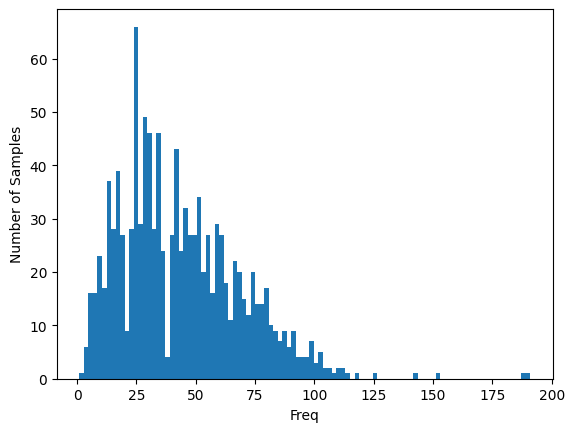

In [7]:
plt.hist(X.sum(axis=1), bins=100)

plt.xlabel('Freq')
plt.ylabel('Number of Samples')
plt.show()

## PLSによる最適な記述子の探索

これより、機械学習によるモデル化を行います。MorganフィンガープリントおよびRDKit記述子を特徴量とする２ケースについて検討します。

### (1) Morganフィンガープリントの場合（P.131）

In [8]:
df_train, df_test = train_test_split(df, 
                                     test_size=.20, 
                                     random_state=42)

目的変数を'measured log solubility in mols per litre'にセットします。

In [9]:
TARGET=['measured log solubility in mols per litre']
ytrain = df_train[TARGET]
ytrain

,measured log solubility in mols per litre
876,-1.400
712,-0.390
554,-4.400
688,-2.676
780,-8.000
...,...
121,-4.800
1044,-2.120
1095,-3.620
860,-0.460


ここではグリッドサーチの手法からMorgan Fingerprintの半径とビット数の総当たりの組み合わせで最も精度が得られる組み合わせを計算します。機械学習モデルはPLSとしています。なお、ここでMorganフィンガープリントは、上記で説明したHash化したMorganとします。

In [ ]:
params={'n_components': np.arange(1,16)}
scores = np.zeros((18,3))
count = 0

for radius in range(1, 4):
    for n_bits in 2**np.arange(5, 11):
        model = GridSearchCV(PLSRegression(), params, cv=5)
        Xtrain = HashedMorgan(n_bits, radius).fit_transform(df_train['mol'])

        model.fit(Xtrain, ytrain)
        
        score_cv = model.best_score_
        scores[count,:] = np.array([radius, n_bits, score_cv])
        count+=1 

### スコアの表示
交差検定の結果を表示します。横軸に半径、縦軸にはビット数としてR2スコアを色別して表示します。

In [ ]:
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['font.size'] = 20

fig,ax=plt.subplots()
im = ax.imshow(scores[:,-1].reshape(3,6).T)
fig.colorbar(im)

ax.set_xticks(range(3))
ax.set_yticks(range(6))
ax.set_xticklabels(range(1,4))
ax.set_yticklabels(map(int,scores[:6,1]))

plt.xlabel('radius')
plt.ylabel('number of but')
plt.savefig('./results/10.3-optim-hashedmorgan-pls.jpg')

plt.show()

### 最良のパラメータを確認
グリッドサーチによる最良のパラメーターは半径２、ビット数256のときにR2スコアとして0.76が得られました。

In [ ]:
ix=scores[:,-1].argmax()
print('radius: {}, n_bits: {} R^2:{:.3f}'.format(*scores[ix,:]))

### (2) RDKit記述子の場合(P.132)
同様にしてRDKit記述子についても機械学習モデルを生成してみましょう。

In [ ]:
from cheminfo.descriptors import RDKitDescriptor

rdcalc = RDKitDescriptor()

X = rdcalc.fit_transform(df_train['mol'])
Xtrain = np.array(X.tolist())

X2 = rdcalc.transform(df_test['mol'])
Xtest = np.array(X2.tolist())

In [ ]:
ytest = df_test[TARGET]

In [ ]:
params = {'n_components': np.arange(1, 16)}
optim = GridSearchCV(PLSRegression(), params)

In [ ]:
optim.fit(Xtrain, ytrain)

In [ ]:
ycalc = optim.predict(Xtrain)
ypred = optim.predict(Xtest)

In [ ]:
print('calc: %.3f'%metrics.r2_score(ytrain,ycalc))
print('cv: %.3f'%optim.best_score_)
print('pred: %.3f'%metrics.r2_score(ytest,ypred))

RDKit記述子の場合は学習データでR2スコアが0.92、検証データで0.89と高い精度になっています。

### 可視化
RDKitのObserved-Predictプロット（Exp-Calcプロット）を描画します。

In [ ]:
plt.plot(ytrain, ycalc, '.')
plt.plot(ytest, ypred, '^')
plt.plot()

plt.axis('square')
plt.xlabel('Exp.')
plt.ylabel('Calc.')
plt.savefig('./results/9.3-yyplot-rdkitpls.jpg')
plt.show()

### モデル保存
上記の予測モデルを保存します。ここではjoblibを使って保存します。

In [ ]:
from joblib import dump
dump(optim, './models/9.3_rdkit_pls.joblib')

joblibは、Pythonのパッケージであり、効率的な並列処理やデータのシリアル化（直列化）をサポートするためのツールです。主な用途は、大規模な計算やデータ処理を高速化するために使用されます。joblibは、NumPyの多次元配列や他のPythonオブジェクトをシリアル化してディスクに保存し、後で再ロードすることで、再計算を回避することができます。

joblibの主な特徴は次のとおりです：

1. 並列処理のサポート：joblibは、マルチコアプロセッサを活用して並列計算を行うことができます。これにより、CPUの複数コアを使用して計算を高速化することができます。特に、大量のデータを処理する際に有効です。

2. メモリ効率の向上：joblibは、メモリ使用量を最小限に抑えるために、効率的なメモリマッピングを使用します。これにより、大規模なデータセットを処理する際のメモリオーバーヘッドを軽減できます。

3. シンプルなAPI：joblibは、Pythonの標準ライブラリの`pickle`モジュールと似たシンプルなAPIを提供します。これにより、既存のコードを比較的簡単にjoblibに移行できます。

joblibの主なユースケースは、機械学習やデータサイエンス、大規模なデータ処理などです。特に、機械学習のモデルのトレーニングやハイパーパラメータの探索など、計算が重い処理において高い効果を発揮します。

使用例を示します：

```python
import joblib

# シリアル化（オブジェクトの保存）
data = [1, 2, 3, 4, 5]
joblib.dump(data, 'data.pkl')

# ロード（オブジェクトの読み込み）
loaded_data = joblib.load('data.pkl')
print(loaded_data)  # [1, 2, 3, 4, 5]
```

この例では、Pythonリスト`data`を`data.pkl`というファイル名で保存し、再度読み込んでいます。このようにして、データの保存と再利用が可能となります。

## 3.適用範囲（AD）の設定
第６回で作成した10,000の仮想化合物にたいして、上記のRDKit記述子をベースとしたPLSモデルによる予測を行います。また、予測結果が信頼できるかを確認するため、底本ではT2指標、Q値から適用範囲を定めています。 


【補足】  
T2指標とQ値は、生産における品質管理に関連する統計的な手法です。主に多変量データを分析し、プロセスの安定性や品質の変化を監視するために使用されます。

1. **T2指標 (T2 Statistic)**:
T2指標は、多変量プロセス監視のための統計的な指標で、プロセス内の変動や異常を検出するのに役立ちます。基本的には、多変量データの平均値と分散の組み合わせを用いて計算されます。T2指標はホットリリースティック法（HOTELLING'S T2法）に基づいています。

T2指標は、以下の手順で計算されます：
1. データセットの平均ベクトル（多変量データの平均値）を計算します。
2. データセットの共分散行列（多変量データの分散共分散行列）を計算します。
3. プロセスから得られたデータの平均ベクトルを計算し、それを基準平均ベクトルと比較します。
4. プロセスから得られたデータの共分散行列を計算し、それを基準共分散行列と比較します。

T2は距離指標であり、その測長には**マハラノビス距離**を用いています。これよりT2値（マハラノビス距離）を計算し、特定の閾値と比較することで、プロセスの異常や変化を監視することができます。

2. **Q値 (Q Statistic)**:
Q値も多変量プロセス監視のための指標で、プロセス内の変動や異常を検出する際に使用されます。T2指標と同様に、Q値も異常を検出するための基準となる閾値と比較されます。

Q値は、データの観測値が平均値からどれだけ離れているかを示す指標で、基本的にはT2指標の計算における差異ベクトルを用いて計算されます。Q値は、各観測値の差異ベクトルの長さを示し、この長さが閾値を超える場合に異常と判定されることがあります。

なお、T2指標、Q値は関数は次のようにdef関数として使います。PLSに対してT2指標、Q値を適用した内容については下記の技術ブログも参照してください。  
https://nirpyresearch.com/outliers-detection-pls-regression-nir-spectroscopy-python/

In [ ]:
def t2_score(data, model):
    "T2値の計算モジュール"
    assert type(data)==pd.DataFrame or type(data)==np.ndarray, "input must be pandas.DataFrame or np.array"
    
    explained_std_ = np.sqrt(model.best_estimator_.x_scores_.var(axis=0))
    scores_whiten = model.transform(data) / explained_std_
    
    return (scores_whiten ** 2.). sum(axis=1)

def q_value(data, model):
    "Q値の計算モジュール"
    assert type(data)==pd.DataFrame or type(data)==np.ndarray, "input must be pandas.DataFrame or np.array"
    
    x_reproduced_ = model.transform(data) @ model.best_estimator_.x_loadings_.T
    
    return ((data - x_reproduced_)**2.).sum(axis=1)

### 適用範囲（AD）の設定
ADの設定範囲はdelaneyの溶解度データの教師データよりt2指標および q値を計算し、その範囲を定めます。Xtrainデータ（教師データ）よりT2指標とQ値を計算し、その95%quantile（２σ）を適用範囲の上限として設定します。

### T2指標およびQ値の計算

In [ ]:
t2_values = t2_score(Xtrain, optim)
q_values = q_value(Xtrain, optim)

### ADの上限値設定
ここではT2指標およびQ値の95%quantile（２σ）を適用範囲の上限として設定しています。

In [ ]:
t2_95q = np.quantile(t2_values, 0.95)
qval_95q = np.quantile(q_values, 0.95)

print('t^2 - 95% quantile', t2_95q, '\nq value - 95% quantile', qval_95q)

### ADの可視化
設定されたADの範囲をプロットします。横軸をT2指標、縦軸をQ値とし、それぞれの95% quantileを破線で表示します。

In [ ]:
plt.plot(t2_values, q_values, 'o')

plt.xlabel('$T^2$ score')
plt.ylabel('$Q$ score')
plt.vlines(t2_95q, ymin=0, ymax=q_values.max(), linestyles='--')
plt.hlines(qval_95q, xmin=0, xmax=t2_values.max(), linestyles='--')

plt.show()

ADの範囲がわかるように軸設定を変更します。

In [ ]:
plt.plot(t2_values, q_values, 'o')

plt.xlabel('$T^2$ score')
plt.ylabel('$Q$ score')

plt.ylim(-1e9,1e12)
plt.vlines(t2_95q, ymin=0, ymax=q_values.max(), linestyles='--')
plt.hlines(qval_95q, xmin=0, xmax=t2_values.max(), linestyles='--')

plt.show()

## 4.スクリーニング
ここでの実演を省略しますが、別に準備する「7_Ex2_Solubility.py」で、第６回で生成した10万の仮想化合物について並列処理によるPLSの予測器にかけて演算します。演算結果をSMILES構造（smi）、溶解度の予測値（ypred）, 当該予測値のt2指標（t2）および q値（q）の4つを.outファイルとして出力します。

In [1]:
from joblib import load as jl_load
import numpy as np
from rdkit.Chem import MolFromSmiles

from cheminfo.descriptors import RDKitDescriptor
from cheminfo.metrics import t2_score, q_value
from multiprocessing import Pool, cpu_count

ModuleNotFoundError: No module named 'joblib'

In [2]:
def processor(argv):
    """予測値とSMILESを文字列で返す関数。multiprocessing.Pool.imap用。"""
    smiles, model = argv
    smi = smiles.strip()

    mol = MolFromSmiles(smi)
    mol.UpdatePropertyCache(strict=True)
    rdcalc = RDKitDescriptor()
    xnew = np.array(rdcalc.transform([mol]))
    
    print(type(xnew))
    
    ypred = model.predict(xnew)
    t2 = t2_score(xnew, model)
    q = q_value(xnew, model)
    return '%s %.8f %.8f %.8f'%(smi, ypred, t2, q)


In [3]:
def count_lines(filename):
    """ファイルの行数を数える関数"""
    with open(filename, 'r')as f:
        c=0
        for _ in f:
            c+=1
    return c

In [ ]:
def main():
    """メイン関数。入力を受け取り、並列処理を実行。"""
    # assert len(argv)>2, "SYNTAX: python src/10.3-screening.py MODEL_FILE.joblib SMILES.smi"
    modelfile = "./models/9.3_rdkit_pls.joblib"
    smilesfile = "./results/mol_quad.smi"

    model = jl_load(modelfile)
    n_counts = count_lines(smilesfile)

    cs = 1000

    model_sampler = (model for _ in range(n_counts))
    outfile = open(smilesfile.replace('.smi', '.out'), 'w')

    with open(smilesfile, 'r') as f:
        with Pool(cpu_count()) as pool:
            "並列処理"
            for ret in pool.imap(processor, zip(f, model_sampler), chunksize=cs):
                outfile.write(ret+'\n')
    outfile.close()# 開いたファイルオブジェクトは必ず閉じる。

In [ ]:
main()

### ADによるスクリーニング
その得られた.outを下記のようにopen関数で読み出して、AD以下に入る化合物をカウントします。

In [40]:
count = 0 
with open('./results/mol_quad.out', 'r') as f:
    for line in f:
        line = line.strip()
        info = line.split()
        
        if float(info[2])<=t2_95q and float(info[3])<=qval_95q:
            count += 1
    else:
        print('予測結果の信頼できる化合物の数', count)

予測結果の信頼できる化合物の数 1934


## まとめ

* 以上のように、ADを設定することで10,000のうち1934化合物に絞り込まれました。この中から予測値が高い化合物が候補材料としてみることができます。
* 1934の化合物の中からどの材料を実際に実験するかは、最終的には人の判断に委ねられます。溶解度の高い上位のランキングのものにするのも一案です。
* 実験計画法としてのベイズ最適化（底本P101）を使って選択する方法もあります。今回のセミナーではベイズ最適化についてはカリキュラムには含めていませんが、機械学習モデルとあわせてベイズ最適化を使うことで効率的にターゲットを絞り込み、所望の化合物（物性）を得るまでの時間を軽減させることができます。